![https://raw.githubusercontent.com/inverted-ai/invertedai/master/docs/images/banner-small.png](https://raw.githubusercontent.com/inverted-ai/invertedai/master/docs/images/banner-small.png)

In [1]:
# Some stuff to get us going:
!pip install invertedai
from IPython.display import clear_output
clear_output()

In [2]:
import os
from IPython.display import clear_output
clear_output()

In [3]:
from IPython.display import display, Image, clear_output
import matplotlib.pyplot as plt
import imageio
import numpy as np
import cv2
import invertedai as iai
import time
clear_output()

# Provide your API key

In [4]:
iai.add_apikey("")

# Setup

Set up the simulation by defining the location, simulation length (1 step = 0.1 second), and some other constants.

In [5]:
location = "iai:drake_street_and_pacific_blvd"
#location = "iai:marine_drive_viewpoint_3"

SIMULATION_LENGTH = 30
RENDERING_FOV = 130
FIGURE_SIZE = 10
AGENT_COUNT = 10
GIF_RATIO = 1.0
GIF_SIZE = 100*FIGURE_SIZE

# Preview the map location

(None, <matplotlib.image.AxesImage at 0x7a6aaa0021d0>)

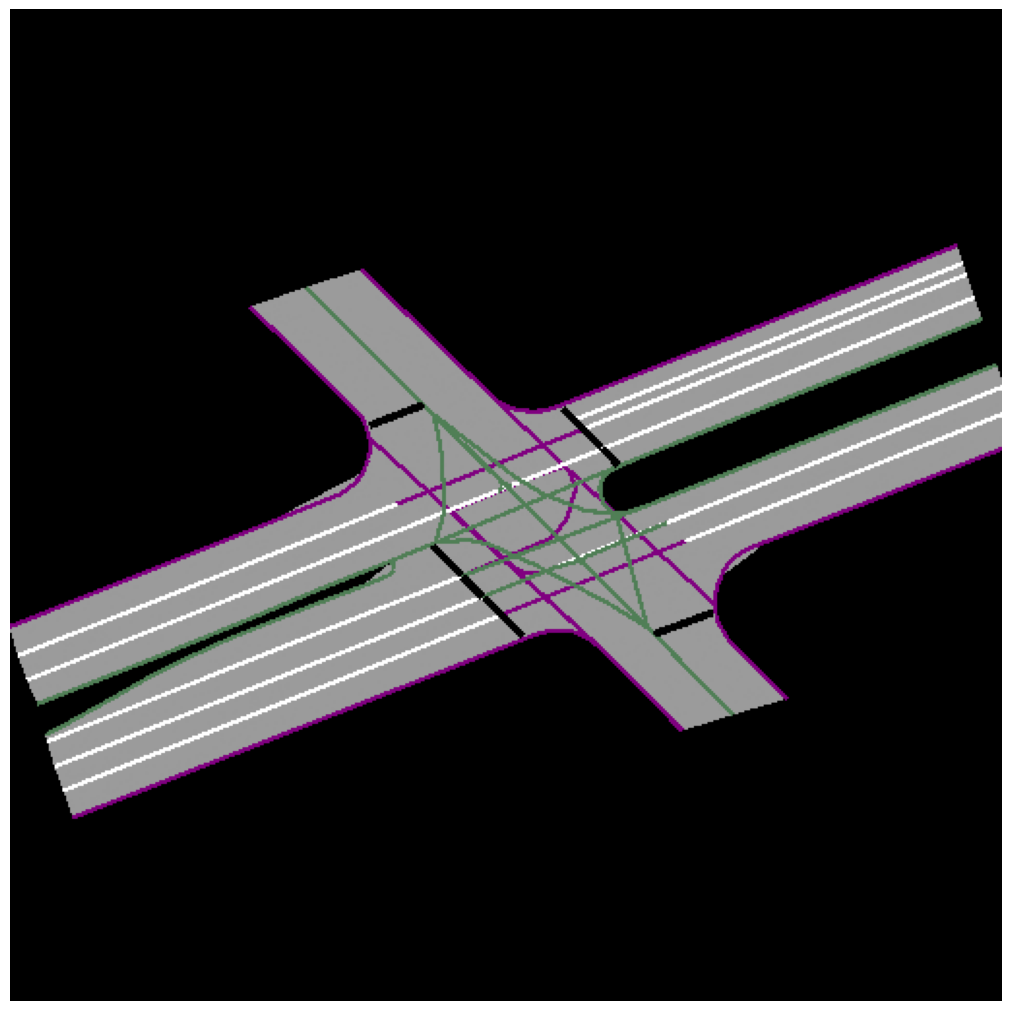

In [9]:
location_info = iai.location_info(location=location,rendering_fov=RENDERING_FOV)
rendered_map = location_info.birdview_image.decode()
fig, ax = plt.subplots(constrained_layout=True, figsize=(FIGURE_SIZE, FIGURE_SIZE))
ax.set_axis_off(), ax.imshow(rendered_map)

In [10]:
scene_plotter = iai.utils.ScenePlotter(rendered_map, RENDERING_FOV, (location_info.map_center.x, location_info.map_center.y), location_info.static_actors)

# Light
First check if there are any traffic-lights on the map and then get the states

In [11]:
if any(actor.agent_type == "traffic-light" for actor in location_info.static_actors):
    scene_has_lights = True
    light_response = iai.light(location=location)
else:
    light_response = None
    scene_has_lights = False

# Initialize
Initialize the simulation by spawning NPCs on the map


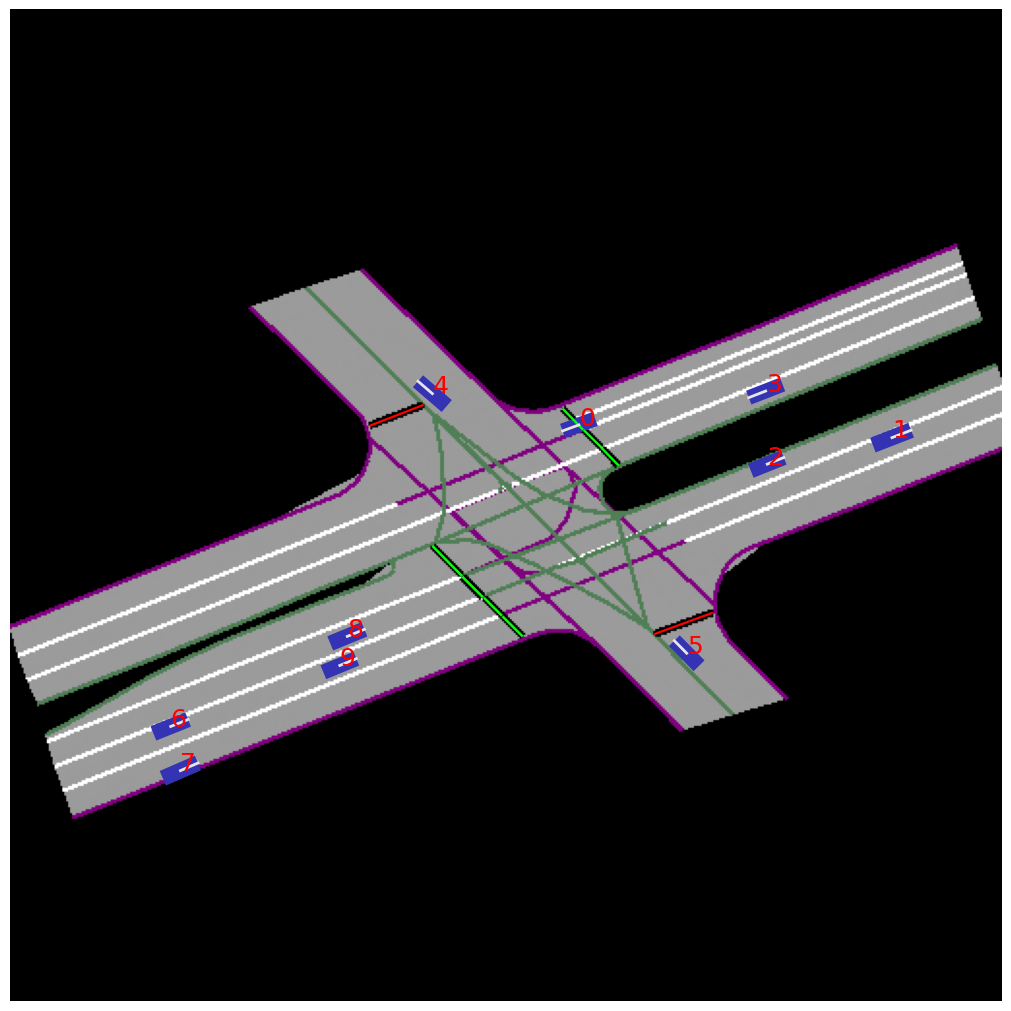

In [27]:
response = iai.initialize(
    location,
    agent_attributes = None,
    states_history = None,
    traffic_light_state_history = [light_response.traffic_lights_states] if scene_has_lights else None,
    get_birdview = False,
    get_infractions = False,
    agent_count = AGENT_COUNT,
)
agent_attributes = response.agent_attributes

fig, ax = plt.subplots(constrained_layout=True, figsize=(FIGURE_SIZE, FIGURE_SIZE))
ax.set_axis_off()
scene_plotter.plot_scene(
    response.agent_states,
    response.agent_attributes,
    traffic_light_states = light_response.traffic_lights_states,
    ax=ax,
    numbers=True,
    velocity_vec=False,
    direction_vec=True
)

# Drive
Start the simulation.\
(Returning the birdviews will casue a much longer response time than running without them.)

In [28]:
agent_attributes = response.agent_attributes
scene_plotter.initialize_recording(response.agent_states, agent_attributes=agent_attributes, traffic_light_states=light_response.traffic_lights_states)
updated_state = response
times = []
for t in range(SIMULATION_LENGTH):
    t0 = time.time()
    light_response = iai.light(location=location, recurrent_states=light_response.recurrent_states) if scene_has_lights else None

    updated_state = iai.drive(
        agent_attributes=agent_attributes,
        agent_states=updated_state.agent_states,
        recurrent_states=updated_state.recurrent_states,
        traffic_lights_states=light_response.traffic_lights_states,
        get_birdview=False,
        location=location,
        get_infractions=False,
    )
    t0b = time.time()
    times.append(t0b - t0)
    scene_plotter.record_step(updated_state.agent_states, traffic_light_states=light_response.traffic_lights_states);
    print(f'Iteration {t}, api call time: {(times[-1]):.2f} s')
    clear_output(wait=True)
print(f'Average time per call: {sum(times)/len(times):.2f} over {len(times)} calls')

Average time per call: 0.86 over 30 calls


In [29]:
%%capture
gif_name = 'iai-drive-npc-only.gif'
fig, ax = plt.subplots(constrained_layout=True, figsize=(FIGURE_SIZE, FIGURE_SIZE))
ax.set_axis_off()
scene_plotter.animate_scene(
    output_name=gif_name,
    ax=ax,
    numbers=False,
    direction_vec=True,
    velocity_vec=False,
    plot_frame_number=True
)

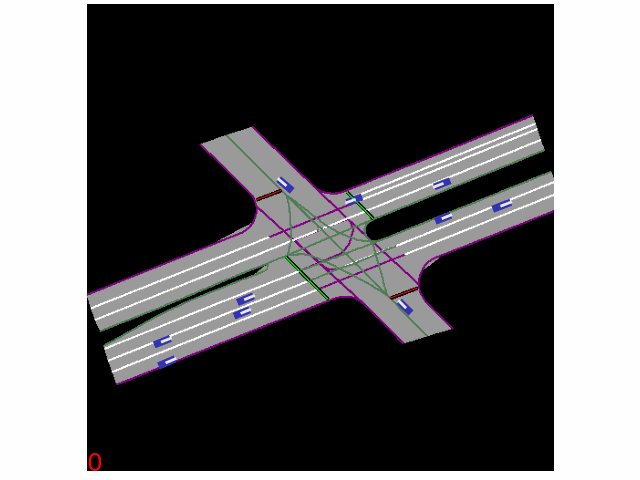

In [30]:
Image(gif_name, width = GIF_SIZE*GIF_RATIO, height = GIF_SIZE)